# Experiment 01: Airline dataset

In this experiment we use [the airline dataset](http://kt.ijs.si/elena_ikonomovska/data.html) to predict arrival delay. The dataset consists of a large amount of records, containing flight arrival and departure details for all the commercial flights within the USA, from October 1987 to April 2008. Its size is around 116 million records and 5.76 GB of memory.



In [1]:
import os,sys
import numpy as np
import pandas as pd
from lightgbm.sklearn import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor
from sklearn.metrics import (confusion_matrix, accuracy_score, roc_auc_score, f1_score, log_loss, precision_score,
                             recall_score)
from libs.loaders import load_airline
from libs.conversion import convert_cols_categorical_to_numeric, convert_related_cols_categorical_to_numeric
from libs.timer import Timer
import pkg_resources
import json
import matplotlib.pylab as plt

print("System version: {}".format(sys.version))
print("XGBoost version: {}".format(pkg_resources.get_distribution('xgboost').version))
print("LightGBM version: {}".format(pkg_resources.get_distribution('lightgbm').version))

%matplotlib inline

System version: 3.5.2 |Anaconda custom (64-bit)| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
XGBoost version: 0.6
LightGBM version: 0.2


# 1) XGBoost vs LightGBM benchmark
In the next section we compare both libraries speed, accuracy and other metrics for the dataset of airline arrival delay. 

### Data loading and management

In [2]:
%%time
df_plane = load_airline()
print(df_plane.shape)

(115069017, 14)
CPU times: user 1min 45s, sys: 13.4 s, total: 1min 59s
Wall time: 4min 17s


In [3]:
df_plane.head()

,Year,Month,DayofMonth,DayofWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,ActualElapsedTime,Origin,Dest,Distance,Diverted,ArrDelay
0,1987,10,1,4,1,556,AA,190,247,SFO,ORD,1846,0,27
1,1987,10,1,4,5,114,EA,57,74,LAX,SFO,337,0,5
2,1987,10,1,4,5,35,HP,351,167,ICT,LAS,987,0,17
3,1987,10,1,4,5,40,DL,251,35,MCO,PBI,142,0,-2
4,1987,10,1,4,8,517,UA,500,208,LAS,ORD,1515,0,17


The first step is to convert the categorical features to numeric features.

In [4]:
%%time
df_plane_numeric = convert_related_cols_categorical_to_numeric(df_plane, col_list=['Origin','Dest'])
del df_plane

CPU times: user 1min 59s, sys: 12.8 s, total: 2min 12s
Wall time: 2min 12s


In [5]:
df_plane_numeric.head()

,Year,Month,DayofMonth,DayofWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,ActualElapsedTime,Origin,Dest,Distance,Diverted,ArrDelay
0,1987,10,1,4,1,556,AA,190,247,0,33,1846,0,27
1,1987,10,1,4,5,114,EA,57,74,1,0,337,0,5
2,1987,10,1,4,5,35,HP,351,167,2,4,987,0,17
3,1987,10,1,4,5,40,DL,251,35,3,41,142,0,-2
4,1987,10,1,4,8,517,UA,500,208,4,33,1515,0,17


In [6]:
%%time
df_plane_numeric = convert_cols_categorical_to_numeric(df_plane_numeric, col_list='UniqueCarrier')


CPU times: user 1min 7s, sys: 9.43 s, total: 1min 17s
Wall time: 1min 17s


In [7]:
df_plane_numeric.head()

,Year,Month,DayofMonth,DayofWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,ActualElapsedTime,Origin,Dest,Distance,Diverted,ArrDelay
0,1987,10,1,4,1,556,0,190,247,0,33,1846,0,27
1,1987,10,1,4,5,114,1,57,74,1,0,337,0,5
2,1987,10,1,4,5,35,2,351,167,2,4,987,0,17
3,1987,10,1,4,5,40,3,251,35,3,41,142,0,-2
4,1987,10,1,4,8,517,4,500,208,4,33,1515,0,17


To simplify the pipeline, we are going to set a classification problem where the goal is to classify wheather a flight has arrived delayed or not. For that we need to binarize the variable `ArrDelay`.

If you want to extend this experiment, you can set a regression problem and try to identify the number of minutes of delay a fight has. Both XGBoost and LightGBM have regression classes.

In [8]:
%%time
df_plane_numeric['ArrDelayBinary'] = 1*(df_plane_numeric['ArrDelay'] > 0)

CPU times: user 41.8 s, sys: 5.41 s, total: 47.2 s
Wall time: 47.3 s


In [9]:
df_plane_numeric.head()

,Year,Month,DayofMonth,DayofWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,ActualElapsedTime,Origin,Dest,Distance,Diverted,ArrDelay,ArrDelayBinary
0,1987,10,1,4,1,556,0,190,247,0,33,1846,0,27,1
1,1987,10,1,4,5,114,1,57,74,1,0,337,0,5,1
2,1987,10,1,4,5,35,2,351,167,2,4,987,0,17,1
3,1987,10,1,4,5,40,3,251,35,3,41,142,0,-2,0
4,1987,10,1,4,8,517,4,500,208,4,33,1515,0,17,1


Once the features are prepared, let's split the dataset into train, validation and test set.

In [10]:
def split_train_val_test_df(df, val_size=0.2, test_size=0.2):
    train, validate, test = np.split(df.sample(frac=1), 
                                     [int((1-val_size-test_size)*len(df)), int((1-test_size)*len(df))])
    return train, validate, test

In [11]:
%%time
train, validate, test = split_train_val_test_df(df_plane_numeric)
print(train.shape)
print(validate.shape)
print(test.shape)

(69041410, 15)
(23013803, 15)
(23013804, 15)
CPU times: user 47.9 s, sys: 15.1 s, total: 1min 3s
Wall time: 1min 3s


In [12]:
def generate_feables(df):
    X = df[df.columns.difference(['ArrDelay', 'ArrDelayBinary'])]
    y = df['ArrDelayBinary']
    return X,y

In [13]:
%%time
X_train, y_train = generate_feables(train)
X_val, y_val = generate_feables(validate)
X_test, y_test = generate_feables(test)


CPU times: user 1.9 s, sys: 2.56 s, total: 4.45 s
Wall time: 4.44 s


### Training 
Now we are going to create two pipelines, one of XGBoost and one for LightGBM. The technology behind both libraries is different, so it is difficult to compare them in the exact same model setting. XGBoost grows the trees depth-wise and controls model complexity with `max_depth`. Instead, LightGBM uses a leaf-wise algorithm and controls the model complexity by `num_leaves`. As a tradeoff, we use XGBoost with `max_depth=8`, which will have max number leaves of 255, and compare it with LightGBM with `num_leaves=255`. 

In [14]:
results_dict = dict()

Let's start with the XGBoost classifier.

In [15]:
xgb_clf_pipeline = XGBRegressor(max_depth=8,
                                n_estimators=50,
                                min_child_weight=30,
                                learning_rate=0.1,
                                subsample=0.80,
                                colsample_bytree=0.80,
                                scale_pos_weight=2,
                                gamma=0.1,
                                reg_lambda=1,
                                subsample=1,
                                seed=77)

In [16]:
with Timer() as t:
    xgb_clf_pipeline.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True, eval_metric='logloss')

[0]	validation_0-logloss:0.679831
[1]	validation_0-logloss:0.670602
[2]	validation_0-logloss:0.660768
[3]	validation_0-logloss:0.6572
[4]	validation_0-logloss:0.649398
[5]	validation_0-logloss:0.647014
[6]	validation_0-logloss:0.641382
[7]	validation_0-logloss:0.635409
[8]	validation_0-logloss:0.633408
[9]	validation_0-logloss:0.631387
[10]	validation_0-logloss:0.62996
[11]	validation_0-logloss:0.628438
[12]	validation_0-logloss:0.622978
[13]	validation_0-logloss:0.618856
[14]	validation_0-logloss:0.614961
[15]	validation_0-logloss:0.611483
[16]	validation_0-logloss:0.610361
[17]	validation_0-logloss:0.607326
[18]	validation_0-logloss:0.604654
[19]	validation_0-logloss:0.603141
[20]	validation_0-logloss:0.600735
[21]	validation_0-logloss:0.598604
[22]	validation_0-logloss:0.597056
[23]	validation_0-logloss:0.59516
[24]	validation_0-logloss:0.594141
[25]	validation_0-logloss:0.592133
[26]	validation_0-logloss:0.591262
[27]	validation_0-logloss:0.589253
[28]	validation_0-logloss:0.586778

In [17]:
results_dict['xgb']={
    'train_time': t.interval
}

Training XGBoost model with leave-wise growth

In [ ]:
xgb_hist_clf_pipeline = XGBRegressor(max_depth=0,
                                    n_estimators=50,
                                    min_child_weight=30,
                                    learning_rate=0.1,
                                    subsample=0.80,
                                    colsample_bytree=0.80,
                                    scale_pos_weight=2,
                                    gamma=0.1,
                                    reg_lambda=1,
                                    subsample=1,
                                    max_leaves=255,
                                    grow_policy='lossguide',
                                    tree_method='hist'
                                    seed=77)

In [ ]:
with Timer() as t:
    xgb_hist_clf_pipeline.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True, eval_metric='logloss')

In [ ]:
results_dict['xgb_hist']={
    'train_time': t.interval
}

Training LightGBM model

In [18]:
lgbm_clf_pipeline = LGBMRegressor(num_leaves=255,
                                  n_estimators=50,
                                  min_child_weight=30,
                                  learning_rate=0.1,
                                  subsample=0.80,
                                  colsample_bytree=0.80,
                                  scale_pos_weight=2,
                                  min_split_gain=0.1,
                                  reg_lambda=1,
                                  subsample=1,
                                  seed=77)

In [19]:
def loglikelood(y_true, y_pred):
    eval_result = log_loss(y_true, y_pred)
    eval_name = 'log_loss'
    is_bigger_better = False
    return eval_name, eval_result, is_bigger_better

In [20]:
with Timer() as t:
    lgbm_clf_pipeline.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True, eval_metric=loglikelood)

[1]	valid_0's log_loss: 0.687287
[2]	valid_0's log_loss: 0.671999
[3]	valid_0's log_loss: 0.657857
[4]	valid_0's log_loss: 0.646298
[5]	valid_0's log_loss: 0.636238
[6]	valid_0's log_loss: 0.627565
[7]	valid_0's log_loss: 0.619954
[8]	valid_0's log_loss: 0.618035
[9]	valid_0's log_loss: 0.611256
[10]	valid_0's log_loss: 0.604873
[11]	valid_0's log_loss: 0.599851
[12]	valid_0's log_loss: 0.598094
[13]	valid_0's log_loss: 0.596536
[14]	valid_0's log_loss: 0.591497
[15]	valid_0's log_loss: 0.590321
[16]	valid_0's log_loss: 0.58874
[17]	valid_0's log_loss: 0.584165
[18]	valid_0's log_loss: 0.582917
[19]	valid_0's log_loss: 0.581757
[20]	valid_0's log_loss: 0.580573
[21]	valid_0's log_loss: 0.579435
[22]	valid_0's log_loss: 0.578217
[23]	valid_0's log_loss: 0.574543
[24]	valid_0's log_loss: 0.571101
[25]	valid_0's log_loss: 0.567958
[26]	valid_0's log_loss: 0.565488
[27]	valid_0's log_loss: 0.564448
[28]	valid_0's log_loss: 0.562955
[29]	valid_0's log_loss: 0.561038
[30]	valid_0's log_loss:

In [21]:
results_dict['lgbm']={
    'train_time': t.interval
}

As it can be seen in the results, given the specific versions and parameters of both XGBoost and LightGBM and in this specific dataset, LightGBM is faster. 

In general terms, leaf-wise algorithms are more efficient, they converge much faster than depth-wise. However, it may cause over-fitting when the data is small or there are too many leaves.

### Evaluation
Now let's evaluate the model in the test set.

In [22]:
with Timer() as t:
    y_prob_xgb = np.clip(xgb_clf_pipeline.predict(X_test), 0.0001, 0.9999)

In [23]:
results_dict['xgb']['test_time'] = t.interval

In [ ]:
with Timer() as t:
    y_prob_xgb_hist = np.clip(xgb_hist_clf_pipeline.predict(X_test), 0.0001, 0.9999)

In [ ]:
results_dict['xgb_hist']['test_time'] = t.interval

In [24]:
with Timer() as t:
    y_prob_lgbm = np.clip(lgbm_clf_pipeline.predict(X_test), 0.0001, 0.9999)

In [25]:
results_dict['lgbm']['test_time'] = t.interval


### Metrics
We are going to obtain some metrics to evaluate the performance of each of the models.

In [26]:
#https://github.com/miguelgfierro/codebase/blob/master/python/machine_learning/metrics.py
def classification_metrics_binary(y_true, y_pred):
    m_acc = accuracy_score(y_true, y_pred)
    m_f1 = f1_score(y_true, y_pred)
    m_precision = precision_score(y_true, y_pred)
    m_recall = recall_score(y_true, y_pred)
    report = {'Accuracy':m_acc, 'Precision':m_precision, 'Recall':m_recall, 'F1':m_f1}
    return report

In [27]:
#https://github.com/miguelgfierro/codebase/blob/master/python/machine_learning/metrics.py
def classification_metrics_binary_prob(y_true, y_prob):
    m_auc = roc_auc_score(y_true, y_prob)
    report = {'AUC':m_auc}
    return report

In [28]:
def binarize_prediction(y, threshold=0.5):
    y_pred = np.where(y > threshold, 1, 0)
    return y_pred

In [29]:
y_pred_xgb = binarize_prediction(y_prob_xgb)
y_pred_xgb_hist = binarize_prediction(y_prob_xgb_hist)
y_pred_lgbm = binarize_prediction(y_prob_lgbm)


In [30]:
report_xgb = classification_metrics_binary(y_test, y_pred_xgb)
report2_xgb = classification_metrics_binary_prob(y_test, y_prob_xgb)
report_xgb.update(report2_xgb)
print(report_xgb)

{'AUC': 0.78681859151636913, 'Recall': 0.61995607596984248, 'Accuracy': 0.71579613696197286, 'F1': 0.67435728923328775, 'Precision': 0.7392243023675803}


In [31]:
results_dict['xgb']['performance'] = report_xgb

In [ ]:
report_xgb_hist = classification_metrics_binary(y_test, y_pred_xgb_hist)
report2_xgb_hist = classification_metrics_binary_prob(y_test, y_prob_xgb_hist)
report_xgb.update(report2_xgb_hist)
print(report_xgb_hist)

In [ ]:
results_dict['xgb_hist']['performance'] = report_xgb_hist

In [32]:
report_lgbm = classification_metrics_binary(y_test, y_pred_lgbm)
report2_lgbm = classification_metrics_binary_prob(y_test, y_prob_lgbm)
report_lgbm.update(report2_lgbm)
print(report_lgbm)

{'AUC': 0.80881607162564162, 'Recall': 0.63225822811183696, 'Accuracy': 0.73549253309014018, 'F1': 0.69411551589200904, 'Precision': 0.76938906504543236}


In [33]:
results_dict['lgbm']['performance'] = report_lgbm

In [34]:
# Results
print(json.dumps(results_dict, indent=4, sort_keys=True))

{
    "lgbm": {
        "performance": {
            "AUC": 0.8088160716256416,
            "Accuracy": 0.7354925330901402,
            "F1": 0.694115515892009,
            "Precision": 0.7693890650454324,
            "Recall": 0.632258228111837
        },
        "test_time": 311.9520166418515,
        "train_time": 638.1008581512142
    },
    "xgb": {
        "performance": {
            "AUC": 0.7868185915163691,
            "Accuracy": 0.7157961369619729,
            "F1": 0.6743572892332877,
            "Precision": 0.7392243023675803,
            "Recall": 0.6199560759698425
        },
        "test_time": 11.566430455073714,
        "train_time": 4280.392433728091
    }
}


The experiment shows a fairly similar performance in both libraries, being LightGBM slightly better.

# 2) Concept drift
In this section we are trying to find concept drift in the dataset to check if retraining is valuable.

### Data management
We are going to pack the data yearly to try to find concept drift

In [35]:
def get_data_list_yearly(df):
    data_yearly = [df[df['Year'] == year] for year in range(1987, 2008)]  
    return data_yearly

In [36]:
%%time
data_yearly_list = get_data_list_yearly(df_plane_numeric)
for subset in data_yearly_list:
    print(subset.shape)

(1287333, 15)
(5126498, 15)
(290827, 15)
(5110527, 15)
(4995005, 15)
(5020651, 15)
(4993587, 15)
(5078411, 15)
(5219140, 15)
(5209326, 15)
(5301999, 15)
(5227051, 15)
(5360018, 15)
(5481303, 15)
(5723673, 15)
(5197860, 15)
(6375689, 15)
(6987729, 15)
(6992838, 15)
(7003802, 15)
(7275288, 15)
CPU times: user 5.81 s, sys: 5.62 s, total: 11.4 s
Wall time: 11.8 s


In [37]:
total_subsets = len(data_yearly_list)
print("Number of years: {}".format(total_subsets))
num_ini = 5

Number of years: 21


In [38]:
def generate_subset(data_yearly_list, num):
    subset = data_yearly_list[0]
    for i in range(1,num):
        subset = pd.concat([subset, data_yearly_list[i]])
    return subset

### Traininig
Let's see what happens when we train on a subset of data and then evaluate in the data of the following years.

In [39]:
%%time
subset_base = generate_subset(data_yearly_list, num_ini)
print(subset_base.shape)

(16810190, 15)
CPU times: user 456 ms, sys: 1.39 s, total: 1.84 s
Wall time: 1.84 s


In [40]:
X_train, y_train = generate_feables(subset_base)

In [41]:
clf = LGBMClassifier(num_leaves=255,
                    n_estimators=100,
                    min_child_weight=30,
                    learning_rate=0.1,
                    subsample=0.80,
                    colsample_bytree=0.80,
                    seed=42)

In [42]:
%%time
clf.fit(X_train, y_train)

CPU times: user 20min 46s, sys: 11min 22s, total: 32min 8s
Wall time: 1min 28s


LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.8, drop_rate=0.1,
        is_unbalance=False, learning_rate=0.1, max_bin=255, max_depth=-1,
        max_drop=50, min_child_samples=10, min_child_weight=30,
        min_split_gain=0, n_estimators=100, nthread=-1, num_leaves=255,
        objective='binary', reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
        seed=42, sigmoid=1.0, silent=True, skip_drop=0.5, subsample=0.8,
        subsample_for_bin=50000, subsample_freq=1, uniform_drop=False,
        xgboost_dart_mode=False)

In [43]:
def predict_accuracy_future_years(clf, data_yearly_list, num_ini):
    total_subsets = len(data_yearly_list)
    accuracy_dict = {}
    for y in range(num_ini, total_subsets):
        year = data_yearly_list[y]['Year'].iloc[0]
        print("Predicting year {}...".format(year))
        X_test, y_test = generate_feables(data_yearly_list[y])
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accuracy_dict[year] = acc
    return accuracy_dict

In [44]:
%%time
accuracy_dict = predict_accuracy_future_years(clf, data_yearly_list, num_ini)
print(accuracy_dict)

Predicting year 1992...
Predicting year 1993...
Predicting year 1994...
Predicting year 1995...
Predicting year 1996...
Predicting year 1997...
Predicting year 1998...
Predicting year 1999...
Predicting year 2000...
Predicting year 2001...
Predicting year 2002...
Predicting year 2003...
Predicting year 2004...
Predicting year 2005...
Predicting year 2006...
Predicting year 2007...
{1992: 0.75635888652686678, 1993: 0.75543231749041317, 1994: 0.74359046560036202, 1995: 0.73115034277677926, 1996: 0.72234987789207283, 1997: 0.71980907578443531, 1998: 0.70528449024124695, 1999: 0.70003570883530619, 2000: 0.68899894787790417, 2001: 0.67335170964518765, 2002: 0.67853347339097247, 2003: 0.68455330866985509, 2004: 0.68012640444413341, 2005: 0.67296453886104612, 2006: 0.66332086486739628, 2007: 0.65060764604782662}
CPU times: user 5h 4min 40s, sys: 3h 55min 33s, total: 9h 14s
Wall time: 24min 12s


From the results we can observe that the accuracy of the model gets worse as the years pass on.

### Retraining
Now let's see what happens when we retrain and evaluate in the data of the following years.

In [45]:
new_init = 15

In [46]:
%%time
subset_retrain = generate_subset(data_yearly_list, new_init)
print(subset_retrain.shape)

(69425349, 15)
CPU times: user 5.81 s, sys: 1min 12s, total: 1min 18s
Wall time: 1min 19s


In [47]:
X_train, y_train = generate_feables(subset_retrain)

In [48]:
clf_retrain = LGBMClassifier(num_leaves=255,
                    n_estimators=100,
                    min_child_weight=30,
                    learning_rate=0.1,
                    subsample=0.80,
                    colsample_bytree=0.80,
                    seed=42)

In [49]:
%%time
clf_retrain.fit(X_train, y_train)

CPU times: user 1h 31min 45s, sys: 40min 34s, total: 2h 12min 19s
Wall time: 6min 56s


LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.8, drop_rate=0.1,
        is_unbalance=False, learning_rate=0.1, max_bin=255, max_depth=-1,
        max_drop=50, min_child_samples=10, min_child_weight=30,
        min_split_gain=0, n_estimators=100, nthread=-1, num_leaves=255,
        objective='binary', reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
        seed=42, sigmoid=1.0, silent=True, skip_drop=0.5, subsample=0.8,
        subsample_for_bin=50000, subsample_freq=1, uniform_drop=False,
        xgboost_dart_mode=False)

In [50]:
%%time
accuracy_retrain = predict_accuracy_future_years(clf_retrain, data_yearly_list, new_init)
print(accuracy_retrain)

Predicting year 2002...
Predicting year 2003...
Predicting year 2004...
Predicting year 2005...
Predicting year 2006...
Predicting year 2007...
{2002: 0.75089709996036835, 2003: 0.74953483458807357, 2004: 0.72610099790647287, 2005: 0.72036803941404048, 2006: 0.70790022333583957, 2007: 0.6962276957283341}
CPU times: user 2h 50min 46s, sys: 1h 12min 58s, total: 4h 3min 44s
Wall time: 11min 14s


### Plot

In [54]:
def plot_metrics(metric1, metric2, legend1=None, legend2=None, x_label=None, y_label=None):
    lists = sorted(metric1.items()) 
    x, y = zip(*lists) 
    fig, ax = plt.subplots()
    ax.plot(x, y, label=legend1, color='#5f9e6f')
    lists2 = sorted(metric2.items()) 
    x2, y2 = zip(*lists2) 
    ax.plot(x2, y2, label=legend2, color='#a2cfae')
    legend = ax.legend(loc=0)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.show()
    return ax

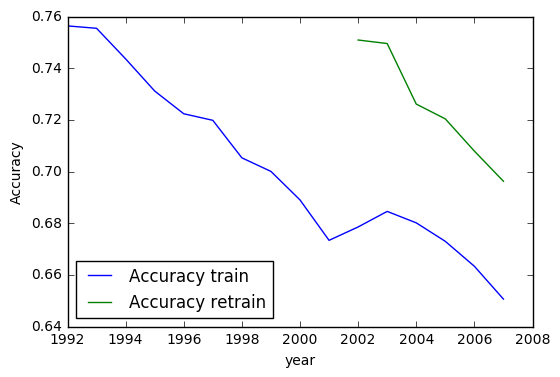

In [55]:
# Airline Retrain Results
ax = plot_metrics(accuracy_dict, accuracy_retrain, legend1='Accuracy train', legend2='Accuracy retrain', x_label='year', 
             y_label='Accuracy')
fig = ax.get_figure()
fig.savefig('airline.svg', bbox_inches='tight')

As it can be seen, the performance is better after retraining. We have found concept drift in this dataset.